# Set up

In [ ]:
# import library

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate, Dropout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from sklearn.model_selection import train_test_split

In [ ]:
# load the train dataset and title (translated to English)
train = pd.read_csv('train_sample.csv')

In [ ]:
train.head()

,Index,posting_id,image,image_phash,title,label_group,title_translate
0,8805,train_2078523022,422eb8e592c3a89e8328133f4a4891c8.jpg,c1b6940f0f591bf4,Kotak Sepatu Lipat / Box Sepatu Lipat / Kotak ...,3486097762,Folding shoe box / Folding shoe box / Cheap tr...
1,4135,train_177965756,1f83c76907311ee2b3d2e8fbf77adc56.jpg,b1cb792dc8ccc2d4,Agar-agar double swallow 7 gram,739195247,Agar-agar double swallow 7 grams
2,16716,train_2485621759,7de256d8c2ef90fca570f60284016a08.jpg,d89895fbc6c4a83a,Sprayer Pompa KYOKAN 2 Liter Dan Merek Lain,1703159951,2 Liter KYOKAN Pump Sprayer And Other Brands
3,7727,train_1226956020,3a5541d69dd5707342bd7bc23d2291b5.jpg,b23ee1cd9c328e1a,Lens Case Motif Character Line,3114936592,Lens Case Motif Character Line
4,32468,train_1217724113,f3538162e71bdffd0b295cc3cac93783.jpg,e5cdcc32929a93cc,Tepung Terigu Hana Emas 1 Kg,4031639568,Wheat Flour Hana Gold 1 Kg


In [ ]:
# load the image to dataframe in array format
img_df = pd.read_csv("images_sample.csv", delimiter=",", engine='c', na_filter=False,
                     dtype={col: np.uint8 for col in pd.read_csv('images_sample.csv', nrows=1).select_dtypes(exclude=['object']).columns})

In [ ]:
img_df.head()

,Index,label_group,image,0,1,2,3,4,5,6,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,101,98,422eb8e592c3a89e8328133f4a4891c8.jpg,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39,111,1f83c76907311ee2b3d2e8fbf77adc56.jpg,223,199,1,224,200,2,226,...,1,211,189,7,67,59,9,0,0,2
2,76,143,7de256d8c2ef90fca570f60284016a08.jpg,224,221,225,218,216,219,217,...,76,118,98,79,136,112,89,161,136,111
3,47,16,3a5541d69dd5707342bd7bc23d2291b5.jpg,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,212,16,f3538162e71bdffd0b295cc3cac93783.jpg,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
X = img_df.iloc[:,3:]
X_rows = img_df.shape[0]

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,223,199,1,224,200,2,226,202,3,225,...,1,211,189,7,67,59,9,0,0,2
2,224,221,225,218,216,219,217,215,218,215,...,76,118,98,79,136,112,89,161,136,111
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
X_rows

500

# Pre-processing

In [ ]:
X_ar = X.to_numpy().reshape((X_rows, 64, 64, 3))

In [ ]:
X_ar[0].shape

(64, 64, 3)

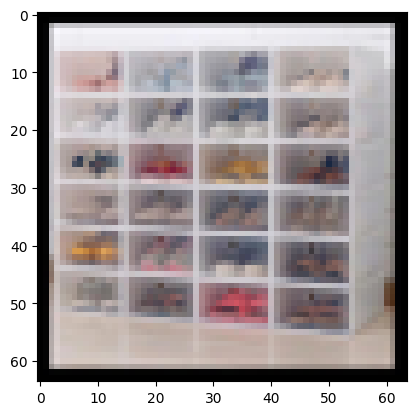

In [ ]:
X0 = X_ar[0].reshape([64,64,3])
plt.imshow(X0)

In [ ]:
# normalize the image
X_ar_normalized = X_ar / 255.0

In [ ]:
train['title_translate']

0      Folding shoe box / Folding shoe box / Cheap tr...
1                       Agar-agar double swallow 7 grams
2           2 Liter KYOKAN Pump Sprayer And Other Brands
3                         Lens Case Motif Character Line
4                             Wheat Flour Hana Gold 1 Kg
                             ...                        
495                                Koko is a pious child
496                        RK - VERONICA'S RIGHT TO KNOW
497      Miranda Keratin Protein Hair Conditioner 100 ml
498       [FREE JARING SOAP] Gluta Collagen Soap [READY]
499                Touch Screen iGlove Motorcycle Gloves
Name: title_translate, Length: 500, dtype: object

In [ ]:
import re, string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# function to clean the translated titles before embedding
def clean_title(title):
    # Remove all non-alphanumeric characters and convert to lowercase
    clean1 = re.sub(r'[^a-zA-Z0-9\s]', '', title).lower()
    # Split the cleaned string into words
    clean2 = re.split('\W+', clean1)
    # Remove stopwords and short words
    title_cleaned = [word for word in clean2 if (word not in stopwords.words('english')) & (len(word) > 2)]
    # Join the cleaned words using a space separator
    title_cleaned = ' '.join(title_cleaned)
    return title_cleaned

In [ ]:
# clean the title in the train dataset
train['title_cleaned'] = train['title_translate'].apply(clean_title)

In [ ]:
train.head(30)

,Index,posting_id,image,image_phash,title,label_group,title_translate,title_cleaned
0,8805,train_2078523022,422eb8e592c3a89e8328133f4a4891c8.jpg,c1b6940f0f591bf4,Kotak Sepatu Lipat / Box Sepatu Lipat / Kotak ...,3486097762,Folding shoe box / Folding shoe box / Cheap tr...,folding shoe box folding shoe box cheap transp...
1,4135,train_177965756,1f83c76907311ee2b3d2e8fbf77adc56.jpg,b1cb792dc8ccc2d4,Agar-agar double swallow 7 gram,739195247,Agar-agar double swallow 7 grams,agaragar double swallow grams
2,16716,train_2485621759,7de256d8c2ef90fca570f60284016a08.jpg,d89895fbc6c4a83a,Sprayer Pompa KYOKAN 2 Liter Dan Merek Lain,1703159951,2 Liter KYOKAN Pump Sprayer And Other Brands,liter kyokan pump sprayer brands
3,7727,train_1226956020,3a5541d69dd5707342bd7bc23d2291b5.jpg,b23ee1cd9c328e1a,Lens Case Motif Character Line,3114936592,Lens Case Motif Character Line,lens case motif character line
4,32468,train_1217724113,f3538162e71bdffd0b295cc3cac93783.jpg,e5cdcc32929a93cc,Tepung Terigu Hana Emas 1 Kg,4031639568,Wheat Flour Hana Gold 1 Kg,wheat flour hana gold
5,29457,train_2982842615,dcbef03ef25f2b160e5b72723ec17a36.jpg,b2c5816c3b77816e,\xe2\x9d\xa4\xef\xb8\x8fCOCOLAND\xe2\x9d\xa4\x...,871679006,\xe2\x9d\xa4\xef\xb8\x8fCOCOLAND\xe2\x9d\xa4\x...,xe2x9dxa4xefxb8x8fcocolandxe2x9dxa4xefxb8x8f 0...
6,30949,train_725991339,e7d08552bf8bec191bd1a361d8c8b0c5.jpg,8f0ff01f706c0f64,GTA Hanger Folding Jemuran Baju Bulat Untuk Ba...,1202808302,GTA Hanger Folding Clothesline Round For Baby ...,gta hanger folding clothesline round baby clot...
7,24878,train_396267439,ba4ca85f3621eabe06ece82881379bc7.jpg,eadb3afc85250187,Baju Bayi 1 Pc Jumper Pendek / Jumper Panjang ...,3645608002,Baby clothes 1 Pc Short Jumper / Long Jumper /...,baby clothes short jumper long jumper romper p...
8,13759,train_37176863,679e9129e9f6ca443602d817c90bb452.jpg,9bce3285b4e5093b,Loyang kue BROWNIES tinggi 7cm | Loyang Perseg...,2951799757,BROWNIES cake pan 7cm high | Rectangular Bakin...,brownies cake pan 7cm high rectangular baking ...
9,6151,train_2275845071,2ead2b6ac1f7d9109517c9d030bf9fd4.jpg,f272caca84359d8d,Air Mineral Prima 330ml Isi 24 Pcs,3805795145,Prima Mineral Water 330ml Contents 24 Pcs,prima mineral water 330ml contents pcs


# Model 1: Keras-CNN Images Only

In [ ]:
# label pre-processing: convert to group then perform onehot encoding

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# convert labels to integers using LabelEncoder
le = LabelEncoder()
labels_int = le.fit_transform(train['label_group'])

# one-hot encode the labels using to_categorical
y = to_categorical(labels_int)

# print the shape of the one-hot encoded labels
print(y.shape)
print(y.shape[1])

(500, 487)
487


In [ ]:
# split to training and validation dataset
X_image_train, X_image_val, y_train, y_val = train_test_split(X_ar_normalized, y, test_size=0.2, random_state=1234)

In [ ]:
# Define the architecture of the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_ar_normalized.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # add dropout here
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # add dropout here
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.25),  # add dropout here
    layers.Dense(64, activation='relu'),
    layers.Dense(y.shape[1])
])

In [ ]:
model.summary()

Model: "sequential_1461"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4383 (Conv2D)        (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4383 (MaxPool  (None, 31, 31, 32)       0         
 ing2D)                                                          
                                                                 
 dropout_4383 (Dropout)      (None, 31, 31, 32)        0         
                                                                 
 conv2d_4384 (Conv2D)        (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4384 (MaxPool  (None, 14, 14, 64)       0         
 ing2D)                                                          
                                                                 
 dropout_4384 (Dropout)      (None, 14, 14, 64)    

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Get the predicted probabilities for each class on the validation set
y_pred_prob = model.predict(X_image_val)

# Get the predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

4/4 [==============================] - 0s 34ms/step


In [ ]:
# Train the model
history = model.fit(X_image_train, 
          y_train, 
          epochs=10, 
          batch_size=32, validation_data=(X_image_val, y_val))

Epoch 1/10
13/13 [==============================] - 1s 105ms/step - loss: 9.3035 - accuracy: 0.0025 - val_loss: 9.0247 - val_accuracy: 0.0000e+00
Epoch 2/10
13/13 [==============================] - 1s 83ms/step - loss: 10.1983 - accuracy: 0.0025 - val_loss: 9.0877 - val_accuracy: 0.0000e+00
Epoch 3/10
13/13 [==============================] - 1s 82ms/step - loss: 9.5011 - accuracy: 0.0025 - val_loss: 10.2191 - val_accuracy: 0.0000e+00
Epoch 4/10
13/13 [==============================] - 1s 55ms/step - loss: 9.9255 - accuracy: 0.0025 - val_loss: 9.1596 - val_accuracy: 0.0000e+00
Epoch 5/10
13/13 [==============================] - 1s 60ms/step - loss: 10.3654 - accuracy: 0.0025 - val_loss: 9.2535 - val_accuracy: 0.0000e+00
Epoch 6/10
13/13 [==============================] - 1s 60ms/step - loss: 10.2838 - accuracy: 0.0025 - val_loss: 9.2208 - val_accuracy: 0.0000e+00
Epoch 7/10
13/13 [==============================] - 1s 55ms/step - loss: 9.9580 - accuracy: 0.0025 - val_loss: 8.4678 - val_a

In [ ]:
val_acc = history.history['val_accuracy']
confidence_level = y_pred_prob[np.arange(len(y_pred)), y_pred]

In [ ]:
# Print the predicted labels, their corresponding confidence levels, and the validation accuracy
for i in range(len(y_pred)):
    print('Predicted label:', y_pred[i], 'with confidence level:', confidence_level[i])
print('Validation accuracy:', val_acc[-1])

Predicted label: 383 with confidence level: 0.1209719
Predicted label: 12 with confidence level: 0.10167323
Predicted label: 12 with confidence level: 0.1183842
Predicted label: 383 with confidence level: 0.12360296
Predicted label: 340 with confidence level: 0.059681997
Predicted label: 12 with confidence level: 0.09141751
Predicted label: 383 with confidence level: 0.11513262
Predicted label: 12 with confidence level: 0.11317882
Predicted label: 125 with confidence level: 0.08825041
Predicted label: 302 with confidence level: 0.10617457
Predicted label: 12 with confidence level: 0.09632969
Predicted label: 12 with confidence level: 0.14382145
Predicted label: 272 with confidence level: 0.0457661
Predicted label: 383 with confidence level: 0.10723706
Predicted label: 85 with confidence level: 0.069563866
Predicted label: 383 with confidence level: 0.120838
Predicted label: 383 with confidence level: 0.111687884
Predicted label: 12 with confidence level: 0.12695199
Predicted label: 383

# Model 2: Tuned Keras-CNN Model Images Only

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define the hyperparameters to explore
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [(3, 3), (5, 5)],
    'dropout_rate': [0.2, 0.3, 0.4],
    'dense_units': [64, 128, 256],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

# Create a function to build the model with the given hyperparameters
def create_model(filters, kernel_size, dropout_rate, dense_units):
    # Define the architecture of the CNN model
    model = tf.keras.Sequential([
        layers.Conv2D(filters, kernel_size, activation='relu', input_shape=X_ar_normalized.shape[1:]),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),
        layers.Conv2D(filters, kernel_size, activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),
        layers.Conv2D(filters, kernel_size, activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(y.shape[1], activation = 'softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
# Create an instance of the KerasClassifier with the function and hyperparameters to explore
model = KerasClassifier(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

<ipython-input-29-326af75e13ea>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


## GridSearch

In [ ]:
# IT TAKES 3 HOUR TO COMPUTE

# Fit the grid search to the data
grid_result = grid.fit(X_image_train, y_train)

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy score: {grid_result.best_score_}")

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Best parameters: {'batch_size': 64, 'dense_units': 64, 'dropout_rate': 0.3, 'epochs': 10, 'filters': 32, 'kernel_size': (3, 3)}
Best accuracy score: 0.007500093585501115


## Best Parameters

In [ ]:
best_params = grid_result.best_params_

In [ ]:
# Result from grid search
best_params = {'batch_size': 64,
 'dense_units': 64,
 'dropout_rate': 0.3,
 'epochs': 10,
 'filters': 32,
 'kernel_size': (3, 3)}

In [ ]:
best_params

{'batch_size': 64,
 'dense_units': 64,
 'dropout_rate': 0.3,
 'epochs': 10,
 'filters': 32,
 'kernel_size': (3, 3)}

In [ ]:
best_model = create_model(dropout_rate=best_params['dropout_rate'],
                          dense_units=best_params['dense_units'],
                          filters=best_params['filters'], 
                          kernel_size=best_params['kernel_size'])

In [ ]:
# Compile the model
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
best_model.summary()

Model: "sequential_1460"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4380 (Conv2D)        (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4380 (MaxPool  (None, 31, 31, 32)       0         
 ing2D)                                                          
                                                                 
 dropout_4380 (Dropout)      (None, 31, 31, 32)        0         
                                                                 
 conv2d_4381 (Conv2D)        (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_4381 (MaxPool  (None, 14, 14, 32)       0         
 ing2D)                                                          
                                                                 
 dropout_4381 (Dropout)      (None, 14, 14, 32)    

In [ ]:
# Get the predicted probabilities for each class on the validation set
y_pred_prob = best_model.predict(X_image_val)

# Get the predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

4/4 [==============================] - 0s 60ms/step


In [ ]:
history = best_model.fit(X_image_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_image_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 87ms/step - loss: 8.2995 - accuracy: 0.0000e+00 - val_loss: 9.1609 - val_accuracy: 0.0100
Epoch 2/10
7/7 [==============================] - 1s 87ms/step - loss: 9.0276 - accuracy: 0.0025 - val_loss: 9.2574 - val_accuracy: 0.0100
Epoch 3/10
7/7 [==============================] - 1s 86ms/step - loss: 9.1976 - accuracy: 0.0000e+00 - val_loss: 8.8417 - val_accuracy: 0.0100
Epoch 4/10
7/7 [==============================] - 1s 81ms/step - loss: 9.2722 - accuracy: 0.0000e+00 - val_loss: 9.9670 - val_accuracy: 0.0100
Epoch 5/10
7/7 [==============================] - 1s 88ms/step - loss: 9.1070 - accuracy: 0.0025 - val_loss: 8.3667 - val_accuracy: 0.0100
Epoch 6/10
7/7 [==============================] - 0s 66ms/step - loss: 8.9582 - accuracy: 0.0000e+00 - val_loss: 9.1338 - val_accuracy: 0.0100
Epoch 7/10
7/7 [==============================] - 0s 64ms/step - loss: 9.3589 - accuracy: 0.0025 - val_loss: 9.1205 - val_accuracy: 0.0100
Epoch 8/10


In [ ]:
val_acc = history.history['val_accuracy']
confidence_level = y_pred_prob[np.arange(len(y_pred)), y_pred]

In [ ]:
# Print the predicted labels, their corresponding confidence levels, and the validation accuracy
for i in range(len(y_pred)):
    print('Predicted label:', y_pred[i], 'with confidence level:', confidence_level[i])
print('Validation accuracy:', val_acc[-1])

Predicted label: 364 with confidence level: 2.8662755
Predicted label: 23 with confidence level: 2.5173025
Predicted label: 364 with confidence level: 2.608202
Predicted label: 364 with confidence level: 2.8859215
Predicted label: 364 with confidence level: 1.6731976
Predicted label: 364 with confidence level: 2.1509423
Predicted label: 364 with confidence level: 2.832812
Predicted label: 364 with confidence level: 2.4166877
Predicted label: 364 with confidence level: 2.0034416
Predicted label: 364 with confidence level: 2.5028708
Predicted label: 364 with confidence level: 2.459528
Predicted label: 117 with confidence level: 2.7080042
Predicted label: 364 with confidence level: 1.2989492
Predicted label: 364 with confidence level: 2.4894762
Predicted label: 117 with confidence level: 1.6038893
Predicted label: 364 with confidence level: 2.9191496
Predicted label: 364 with confidence level: 2.6031835
Predicted label: 364 with confidence level: 2.9204614
Predicted label: 23 with confide

# Model 3: TFIDF-CNN Model using the best hyperparameters

To create a model that takes two inputs, we need to use the Functional API instead of the Sequential API.

The Sequential API is a straightforward way to create a neural network model by stacking layers on top of each other in a linear fashion. However, when dealing with models that have multiple inputs or outputs, the Sequential API is not sufficient.

The Functional API, on the other hand, provides more flexibility in building complex models with multiple inputs and outputs. It allows for more control over how the inputs and outputs are connected to the layers and how the data flows through the network. This flexibility is achieved by defining the input and output layers separately, then connecting the layers using the functional API's various methods.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X_image_train, X_image_val, X_text_train, X_text_val, y_train, y_val = train_test_split(X_ar_normalized, train['title_clean'], y, test_size=0.05, random_state=1234)

In [ ]:
# Define the neural network model
# Use a convolutional neural network (CNN) to process the image data.
# Use a recurrent neural network (RNN) to process the text data.
# Combine the outputs of the two networks using a concatenation layer.
# Add dense layers to the combined output to make the final prediction.

# define the image input
image_input = layers.Input(shape=X_ar_normalized.shape[1:], name='image_input')

# define the convolutional layers for the image input
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)  # add dropout here
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)  # add dropout here
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = Dropout(0.25)(x)  # add dropout here
x = layers.Dense(64, activation='relu')(x)

In [ ]:
# define the text input
text_input = layers.Input(shape=(None,), dtype='string', name='text_input')

In [ ]:
# define the TfidfVectorizer to transform the text input
tfidf = TfidfVectorizer()
# text_features = tfidf.fit_transform(train['title_clean'])
text_features_train = tfidf.fit_transform(X_text_train)
text_features_val = tfidf.transform(X_text_val)
text_features_input = layers.Input(shape=(text_features_train.shape[1],), name='text_features_input')

In [ ]:
# concatenate the image and text features
concatenated = layers.concatenate([x, text_features_input])

In [ ]:
# define the output layer
output_layer = Dense(487, activation='softmax', name='output')(concatenated) #Need to change if more group labels

In [ ]:
# define the model with the two inputs and one output
model1 = Model(inputs=[image_input, text_features_input], outputs=output_layer)

In [ ]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 62, 62, 32)   896         ['image_input[0][0]']            
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 31, 31, 32)  0           ['conv2d_9[0][0]']               
                                                                                                  
 dropout_9 (Dropout)            (None, 31, 31, 32)   0           ['max_pooling2d_6[0][0]']        
                                                                                            

In [ ]:
# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
# history = model1.fit({'image_input': X_image_train, 'text_features_input': text_features_train.toarray()}, 
#           y_train, 
#           epochs=10, 
#           batch_size=32)

history = model1.fit(x=[X_image_train, text_features_train.toarray()], y=y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=([X_image_val, text_features_val.toarray()], y_val))


Epoch 1/10
8/8 [==============================] - 3s 367ms/step - loss: 6.2031 - accuracy: 0.0000e+00 - val_loss: 6.1923 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 3s 405ms/step - loss: 6.1715 - accuracy: 0.0084 - val_loss: 6.2012 - val_accuracy: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 3s 343ms/step - loss: 6.1550 - accuracy: 0.0505 - val_loss: 6.2184 - val_accuracy: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 3s 332ms/step - loss: 6.1377 - accuracy: 0.0674 - val_loss: 6.2717 - val_accuracy: 0.0000e+00
Epoch 5/10
8/8 [==============================] - 3s 345ms/step - loss: 6.1217 - accuracy: 0.0400 - val_loss: 6.4187 - val_accuracy: 0.0000e+00
Epoch 6/10
8/8 [==============================] - 3s 402ms/step - loss: 6.0927 - accuracy: 0.0253 - val_loss: 6.4605 - val_accuracy: 0.0000e+00
Epoch 7/10
8/8 [==============================] - 3s 371ms/step - loss: 6.0680 - accuracy: 0.0211 - val_loss: 6.8884 - val_accuracy:

In [ ]:
# Get the predicted probabilities for each class on the validation set
y_pred_prob = model1.predict([X_image_val, text_features_val.toarray()])

# Get the predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

val_acc = history.history['val_accuracy']
confidence_level = y_pred_prob[np.arange(len(y_pred)), y_pred]

1/1 [==============================] - 0s 55ms/step


In [ ]:
# Print the predicted labels, their corresponding confidence levels, and the validation accuracy
for i in range(len(y_pred)):
    print('Predicted label:', y_pred[i], 'with confidence level:', confidence_level[i])
print('Validation accuracy:', val_acc[-1])

Predicted label: 179 with confidence level: 0.005487332
Predicted label: 178 with confidence level: 0.0036625364
Predicted label: 486 with confidence level: 0.0030530624
Predicted label: 22 with confidence level: 0.0050520813
Predicted label: 486 with confidence level: 0.0028384922
Predicted label: 486 with confidence level: 0.0027603135
Predicted label: 22 with confidence level: 0.0030145885
Predicted label: 335 with confidence level: 0.0026280275
Predicted label: 486 with confidence level: 0.0027077685
Predicted label: 486 with confidence level: 0.0025601801
Predicted label: 179 with confidence level: 0.0044361167
Predicted label: 486 with confidence level: 0.0027101
Predicted label: 486 with confidence level: 0.0024890017
Predicted label: 22 with confidence level: 0.0034950976
Predicted label: 486 with confidence level: 0.0027376963
Predicted label: 179 with confidence level: 0.0033801359
Predicted label: 179 with confidence level: 0.0037994399
Predicted label: 22 with confidence le